### 本课提纲
- 文本的基本处理
- 用神经网络预测文本类别
- 用循环神经网络进行预测

在人工智能领域，我们遇到的数据除了常规的结构化数据，更多的是那些非结构化的数据，例如人们的声音，图片，视频，以及各种文本资料。上节课我们学习了如何对图片进行训练建模，本次我们来尝试一下对于文本的建模训练。

### 1. 文本的基本处理

本课所使用的例子是由若干个文本文件组成，每个文件是一个国家里常见的人名，我们的目标是要能够根据人名来判断它来自哪个国家。

In [2]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 列出所有硬盘中目录下的文件 
def findFiles(path): 
    return glob.glob(path)

path = '../data/names/*.txt'
print(len(findFiles(path)))
print(findFiles(path))



18
['../data/names/Czech.txt', '../data/names/German.txt', '../data/names/Arabic.txt', '../data/names/Japanese.txt', '../data/names/Chinese.txt', '../data/names/Vietnamese.txt', '../data/names/Russian.txt', '../data/names/French.txt', '../data/names/Irish.txt', '../data/names/English.txt', '../data/names/Spanish.txt', '../data/names/Greek.txt', '../data/names/Italian.txt', '../data/names/Portuguese.txt', '../data/names/Scottish.txt', '../data/names/Dutch.txt', '../data/names/Korean.txt', '../data/names/Polish.txt']


我们可以看一下这些文件中的内容，如果你有一个文本编辑器的话，可以直接打开这些txt文件中的一个观察一下，或者也可以在python环境中，取某个文件的前几行内容观察。

In [3]:
filename = '../data/names/Chinese.txt'
content = []
with open(filename) as f:
    for i,c in enumerate(f):
        content.append(c)
        if i>5: 
            break

可以看到，我们获取了某个文件的前六行内容，看到里面都是类似英文的字符串，但其中有一些不熟悉的符号，例如“\n”，这实际上表示的回车符号。

In [4]:
content

['Ang\n', 'Au-Yong\n', 'Bai\n', 'Ban\n', 'Bao\n', 'Bei\n', 'Bian\n']

除了回车符号，这些字符串中很可能包括一些我们不希望处理的杂乱符号，所以我们定义一个希望处理的字符集，这是为了简化问题。

In [5]:
all_letters = string.ascii_letters + " .,;'"
print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


这里定义的函数unicodeToAscii，是吧一些可能的杂乱符号统一化为Ascii字符集

In [6]:
def unicodeToAscii(s):
    output =[c for c in unicodedata.normalize('NFD', s) 
             if c in all_letters]
    return ''.join(output)

print(unicodeToAscii('Ślusàrski'))

Slusarski


然后我们需要准备其它的辅助函数，来帮助处理文本到训练数据这个步骤。

In [7]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []


定义了一个函数，readLines是用于读取某个文件，同时对文件中的字符串进行了标准化。然后利用一个for循环，把所有path中的文件都进行了处理，将所有的18类名字都存放在一个字典中，这个字典中有18个key-value对，每个key对应了一种语言，value中是这种语言对应的所有名字构成的list。

In [8]:
# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
        return [unicodeToAscii(line) for line in lines]

for filename in findFiles(path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines



我们可以看下，从字典category_lines中取出意大利名字前五个。

In [9]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


再保存两个变量，n_letters是所有我们用到的字符串的字母数量，n_categories是所有的语言的类别数量。我们一共用到了57个字符数，有18数语言。

In [10]:
n_letters = len(all_letters)
n_categories = len(all_categories)

因为计算机是不明白也读不懂字符的，所以需要将这些字符转成数值的形式，letterToIndex函数是将一个字符转成编号，letterToTensor函数是将一个字符转成独热编码形式，lineToTensor函数是将一个名字转成编码形式。

In [11]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(1,len(line),n_letters)
    for li, letter in enumerate(line):
        tensor[0][li][letterToIndex(letter)] = 1
    return tensor


In [12]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([1, 5, 57])


定义一个函数，用于随机抽取一条名字，作为建模训练数据。

In [13]:
# 随机选择样本
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Dutch / line = Schoonraad
category = Vietnamese / line = Han
category = German / line = Bretz
category = Czech / line = Alt
category = Portuguese / line = Cardozo
category = Japanese / line = Yamazaki
category = Chinese / line = Kuai
category = Korean / line = Gu
category = Arabic / line = Essa
category = Dutch / line = Rumpade


### 2. 用全连接的神经网络判断文本

下面使用我们学到过的pytorch来构造全连接的神经网络，用于判断人名的建模。

In [14]:
input_size = len(all_letters)
num_layers = 1
num_classes = len(all_categories)
hidden_size = 128
n_iters = 100000
print_every = 5000
plot_every = 1000
learning_rate=0.001

In [15]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [16]:
model = NeuralNet(input_size, hidden_size, num_classes)

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  


In [19]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []
# Train the model
for i in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()

    # Forward pass
    outputs = model(line_tensor.sum(1))
    labels = category_tensor
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_loss += loss.data.numpy()

    if i % print_every == 0:
        print('%d %d%% %.4f ' % (i, i / n_iters * 100, current_loss/print_every))
        all_losses.append(current_loss/print_every)
        current_loss = 0



5000 5% 2.0640 
10000 10% 1.5935 
15000 15% 1.4687 
20000 20% 1.3474 
25000 25% 1.2436 
30000 30% 1.1926 
35000 35% 1.0950 
40000 40% 1.0487 
45000 45% 1.0285 
50000 50% 0.9580 
55000 55% 0.9115 
60000 60% 0.8895 
65000 65% 0.8485 
70000 70% 0.8523 
75000 75% 0.8157 
80000 80% 0.7792 
85000 85% 0.7505 
90000 90% 0.7600 
95000 95% 0.7457 
100000 100% 0.7189 


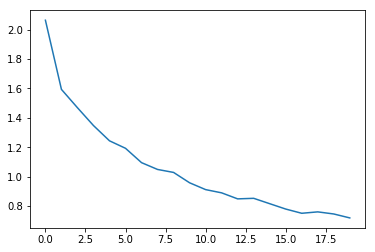

In [20]:
plt.plot(all_losses);

### 使用循环神经网络处理文本

In [21]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):        
        # Forward propagate LSTM
        out, _ = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.fc(out[:, -1, :])  
        return out


In [22]:

model = RNN(input_size, hidden_size, num_layers, num_classes)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [23]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []
# Train the model
for i in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()

    # Forward pass
    outputs = model(line_tensor)
    labels = category_tensor
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_loss += loss.data.numpy()

    if i % print_every == 0:
        print('%d %d%% %.4f ' % (i, i / n_iters * 100, current_loss/print_every))
        all_losses.append(current_loss/print_every)
        current_loss = 0


5000 5% 2.0966 
10000 10% 1.4443 
15000 15% 1.1983 
20000 20% 0.9941 
25000 25% 0.8725 
30000 30% 0.7408 
35000 35% 0.6591 
40000 40% 0.5864 
45000 45% 0.5432 
50000 50% 0.5005 
55000 55% 0.4793 
60000 60% 0.4541 
65000 65% 0.3987 
70000 70% 0.4028 
75000 75% 0.3767 
80000 80% 0.3573 
85000 85% 0.3421 
90000 90% 0.3622 
95000 95% 0.3286 
100000 100% 0.3199 


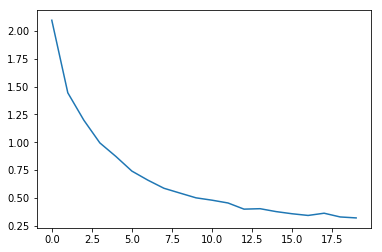

In [26]:
plt.plot(all_losses);

In [27]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = model(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Satoshi')


> Dovesky
(10.05) Russian
(6.70) Czech
(5.62) English

> Satoshi
(6.49) Japanese
(4.13) Arabic
(3.08) Italian


### 本课小结：
- 本课学习了神经网络在文本领域的应用，具体而言是文本分类的应用，这种情况下文本被转换为数值表示，这种称之为独热编码。
- 使用全连接的神经网络将编码后的文本表示进行输入，效果一般，因为这种训练方法只考虑了某个字母是否出现，而没有考虑顺序的因素。
- 使用循环神经网络，考虑了输入字母的顺序因素，所以效果要比全连接的神经网络要好很多。